## Deploy  `ct-scan-body-part-detector` Model Package from AWS Marketplace 


This sample notebook shows you how to deploy [`ct-scan-body-part-detector`](http://aws.com) using Amazon SageMaker.

#### Pre-requisites:

1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.

1. Ensure that IAM role used has **AmazonSageMakerFullAccess**

1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to [`ct-scan-body-part-detector`](http://aws.com). If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)

#### Contents:
1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-input-payload)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Visualize output](#D.-Visualize-output)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
3. [Perform batch inference](#3.-Perform-batch-inference) 
4. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))
    

#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page <font color='red'> For Seller to update:[Title_of_your_product](Provide link to your marketplace listing of your product).</font>
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

In [8]:
model_package_arn = "arn:aws:sagemaker:us-west-2:535328050074:model-package/ct-scan-body-part-detector-v0"

In [9]:
# download dependent libraries for reading dicom images and tags.

In [10]:
! pip install SimpleITK
! pip install pydicom

In [11]:
# create image download, read, write and nifti-to-json serialization methods.

In [12]:
import os
import requests
from base64 import b64encode,b64decode
import json
import zipfile
import numpy as np
import pydicom
import SimpleITK as sitk
import matplotlib.pyplot as plt

def resample_img(itk_image, out_spacing):
    
    # Resample images to out_spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

# custom resample
TARGET_XY_SIZE = 128
TARGET_Z_SIZE = 100
def imread(myinput,downsample=True):
    if isinstance(myinput,list):
        file_list = myinput
        dicom_list = []
        for image_file in file_list:
            ds=pydicom.dcmread(image_file)
            dicom_list.append((ds.InstanceNumber,image_file))
            dicom_list = sorted(dicom_list,key=lambda x:x[0])
        dicom_names = [x[1] for x in dicom_list]
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(dicom_names)
    else:
        file_path = myinput
        reader= sitk.ImageFileReader()
        reader.SetFileName(file_path)
        
    img_obj = reader.Execute()
    if downsample:
        spacing = list(img_obj.GetSpacing())
        size = list(img_obj.GetSize())
        
        # scale down to 128x128 for dimensions 0 and 1
        spacing[0] = spacing[0]*(size[0]/float(TARGET_XY_SIZE))
        spacing[1] = spacing[1]*(size[1]/float(TARGET_XY_SIZE))
        
        # scale to no more than 100 scans (for dimension 2)
        if size[2] < TARGET_Z_SIZE:
            factor = 1
        else:
            factor = size[2]/float(TARGET_Z_SIZE)
        spacing[2] = spacing[2]*factor
        
        img_obj = resample_img(img_obj, out_spacing=spacing)
        
    return img_obj

def imwrite(fpath,img_obj,use_compression=True):
    print(img_obj.GetSize())
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(fpath)
    writer.SetUseCompression(use_compression)
    writer.Execute(img_obj)

def download_images(series_instance_uid,image_root="."):
    url = f"https://services.cancerimagingarchive.net/services/v4/TCIA/query/getImage?SeriesInstanceUID={series_instance_uid}"
    zip_file_path = os.path.join(image_root,series_instance_uid+'.zip')
    r = requests.get(url, allow_redirects=True)
    print(r.status_code)
    if r.status_code != 200:
        raise LookupError(f"ohoh {r.status_code}!")
    open(zip_file_path, 'wb').write(r.content)
    folder_path = os.path.join(image_root,series_instance_uid)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(folder_path)
    return folder_path

def convert_to_nifti(folder_path,series_instance_uid,image_root=None):
    file_list = [os.path.join(folder_path,x) for x in os.listdir(folder_path)]
    img_obj = imread(file_list)
    nii_gz_path = os.path.join(image_root,f'{series_instance_uid}.nii.gz')
    imwrite(nii_gz_path,img_obj)
    return nii_gz_path

ENCODING = 'utf-8'
def convert_to_json(input_file):
    with open(input_file, 'rb') as open_file:
        byte_content = open_file.read()
    base64_bytes = b64encode(byte_content)
    base64_string = base64_bytes.decode(ENCODING)
    myjson = {"niigz":base64_string}
    return myjson

def upload_to_s3(input_file):
    s3_prefix = 'ct-sample-images'
    rawdata_s3_prefix = '{}'.format(s3_prefix)
    s3_uri = sess.upload_data(path=input_file, key_prefix=rawdata_s3_prefix)
    return s3_uri


In [13]:
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from urllib.parse import urlparse
import numpy as np
import boto3

In [14]:
role = get_execution_role()

sagemaker_session = sage.Session()

bucket = sagemaker_session.default_bucket()
runtime = boto3.client("runtime.sagemaker")

print(role)
print(bucket)

arn:aws:iam::535328050074:role/MyAmazonSageMaker-ExecutionRole
sagemaker-us-west-2-535328050074


### 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [23]:
model_name = "ct-scan-body-part-detector"

content_type = "application/json"

real_time_inference_instance_type = 'ml.m5.xlarge'
batch_transform_inference_instance_type = 'ml.m5.xlarge'

In [27]:
# create a deployable model from the model package.
model = ModelPackage(
    role=role, model_package_arn=model_package_arn, sagemaker_session=sagemaker_session
)

# Deploy the model
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

#### A. Create an endpoint

Once endpoint has been created, you would be able to perform real-time inference.

#### B. Create input payload

In [11]:
# Download images, serialize as json

In [70]:
! mkdir -p /tmp/myimages && \
  export series_instance_uid=1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075 && \
  aws s3 cp s3://sawtelle/public/sample-images/${series_instance_uid}.zip /tmp/myimages/images.zip && \
  export myfolder=/tmp/myimages/${series_instance_uid} && \
  mkdir -p ${myfolder} && \
  cd ${myfolder} && \
  unzip -qq /tmp/myimages/images.zip && \
  echo download done!

download: s3://sawtelle/public/sample-images/1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075.zip to ../../../../../tmp/myimages/images.zip
download done!


In [52]:
series_instance_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075'
image_root = "/tmp/myimages"
os.makedirs(image_root,exist_ok=True)

# download images from TCIA (TCIA sometimes is down, thus we opted for above s3 path)
tcia = True
if tcia:
    folder_path = download_images(series_instance_uid,image_root=image_root)
    nii_gz_path = convert_to_nifti(folder_path,series_instance_uid,image_root=image_root)
else:
    folder_path = 'images'
    nii_gz_path = convert_to_nifti(folder_path,series_instance_uid,image_root=image_root)
mypayload = convert_to_json(nii_gz_path)

(128, 128, 100)


In [33]:
with open('mypayload.txt','w') as f:
    f.write(json.dumps(mypayload))
with open('mypayload.txt','r') as f:
    mypayloadstr=f.read()
    
mypayload.txt

nii.gz file is now converted to json format in `mypayload.txt`, with a size of 2.8MB as shown below

In [54]:
!ls mypayload.txt -lh

-rw-rw-r-- 1 ec2-user ec2-user 2.8M Oct  1 18:56 mypayload.txt


#### C. Perform real-time inference

In [55]:
!echo $sagemaker_session.boto_region_name

us-west-2


#### perform inference with aws cli:

In [56]:
# $sagemaker_session.boto_region_name
!export model_name=ct-scan-body-part-detector \
 && export file_name=mypayload.txt \
 && export content_type=application/json \
 && export output_file_name=response_output.json \
 && echo $model_name $file_name $content_type $output_file_name \
 && aws sagemaker-runtime invoke-endpoint \
    --endpoint-name "$model_name" \
    --body "fileb://$file_name" \
    --content-type "$content_type" \
    --region "us-west-2" \
    "$output_file_name"

ct-scan-body-part-detector mypayload.txt application/json response_output.json
{
    "ContentType": "application/json",
    "InvokedProductionVariant": "AllTraffic"
}


In [57]:
!cat response_output.json

{"body_parts":{"abdomen":{"height":57.2,"unit":"mm"},"chest":{"height":207.9,"unit":"mm"},"head":{"height":0.0,"unit":"mm"},"lower_limb":{"height":0.0,"unit":"mm"},"neck":{"height":36.2,"unit":"mm"},"pelvis":{"height":0.0,"unit":"mm"}},"cap_completeness":{"abdomen":false,"chest":true,"pelvis":false},"head_first":true}


#### alterminatively, call with boto3:

In [59]:
client = boto3.client('sagemaker-runtime')

endpoint_name = "ct-scan-body-part-detector"
content_type = "application/json"
accept = "application/json"
payload = mypayloadstr # Payload for inference.

response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType=content_type,
    Accept=accept,
    Body=payload
    )

print(response)
result = json.loads(response['Body'].read().decode())


{'ResponseMetadata': {'RequestId': '4a4d22e8-5c06-483a-a62a-ea7ef43e3d10', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '4a4d22e8-5c06-483a-a62a-ea7ef43e3d10', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Fri, 01 Oct 2021 19:13:08 GMT', 'content-type': 'application/json', 'content-length': '320'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7fbbf8820e80>}


In [60]:
print(result)

{'body_parts': {'abdomen': {'height': 57.2, 'unit': 'mm'}, 'chest': {'height': 207.9, 'unit': 'mm'}, 'head': {'height': 0.0, 'unit': 'mm'}, 'lower_limb': {'height': 0.0, 'unit': 'mm'}, 'neck': {'height': 36.2, 'unit': 'mm'}, 'pelvis': {'height': 0.0, 'unit': 'mm'}}, 'cap_completeness': {'abdomen': False, 'chest': True, 'pelvis': False}, 'head_first': True}


#### D. Visualize output

We print out the model output `results` and show a coronal slice of the input 3d image.
confirming the below findings from the model:
   + presence of neck(shoulder), chest and abdomen
   + chest body part is complete (presence of shoulder and abdomen)
   + scan is imaged head-first (as oppposed to feet first)

spacing: (0.609375, 0.609375, 1.25), size: (512, 512, 241)


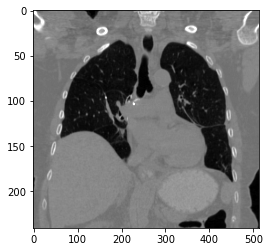

In [77]:
series_instance_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075'
folder_path = os.path.join(image_root,series_instance_uid)
file_list = [os.path.join(folder_path,x) for x in os.listdir(folder_path)]
img_obj = imread(file_list,downsample=False)

arr = sitk.GetArrayFromImage(img_obj)
spacing = img_obj.GetSpacing()
size = img_obj.GetSize()
print(f'spacing: {spacing}, size: {size}')
plt.imshow(arr[:,256,:].squeeze(),cmap='gray',aspect=spacing[2]/spacing[0],vmin=-1000,vmax=1000)

In [78]:
print(result)

{'body_parts': {'abdomen': {'height': 57.2, 'unit': 'mm'}, 'chest': {'height': 207.9, 'unit': 'mm'}, 'head': {'height': 0.0, 'unit': 'mm'}, 'lower_limb': {'height': 0.0, 'unit': 'mm'}, 'neck': {'height': 36.2, 'unit': 'mm'}, 'pelvis': {'height': 0.0, 'unit': 'mm'}}, 'cap_completeness': {'abdomen': False, 'chest': True, 'pelvis': False}, 'head_first': True}


#### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [79]:
model.sagemaker_session.delete_endpoint(model_name)
model.sagemaker_session.delete_endpoint_config(model_name)

### 3. Prepare for batch inference

In [16]:
# unseen dataset from tcia 
# collection id # anatomical-site # series-isntance-uid
# OPC-Radiomics, # head-and-neck # '1.3.6.1.4.1.14519.5.2.1.8666.3098.135047974513108102532692126459'
# CPTAC-SAR # whole-body # '1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668'
# COVID-19-NY-SBU # abdomen-pelvis # '1.3.6.1.4.1.14519.5.2.1.99.1071.20813077754558159326970236991440'

series_instance_uid_list = [
    "1.3.6.1.4.1.14519.5.2.1.8666.3098.135047974513108102532692126459",
    "1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668",
    "1.3.6.1.4.1.14519.5.2.1.99.1071.20813077754558159326970236991440",
]

In [17]:
niigz_list = []
image_root = "/tmp/myimages"
os.makedirs(image_root,exist_ok=True)
for suid in series_instance_uid_list:
    nii_gz_path = os.path.join(image_root,f'{suid}.nii.gz')
    folder_path = os.path.join(image_root,suid)
    if not os.path.exists(folder_path):
        folder_path = download_images(suid,image_root=image_root)        
    if not os.path.exists(nii_gz_path):
        nii_gz_path = convert_to_nifti(folder_path,suid,image_root=image_root)
    myjson = convert_to_json(nii_gz_path)
    niigz_list.append(myjson)
    
batch_file = 'niigz-jsonlines.txt'
with open(batch_file,'w') as f:
    for x in niigz_list:
        f.write(json.dumps(x)+'\n')

In [18]:
!ls -lh niigz-jsonlines.txt

-rw-rw-r-- 1 ec2-user ec2-user 6.5M Oct  1 19:55 niigz-jsonlines.txt


### 3. Perform batch inference

In this section, you will perform batch inference using multiple input payloads together. If you are not familiar with batch transform, and want to learn more, see these links:
1. [How it works](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html)
2. [How to run a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html)

In [28]:
# upload the batch-transform job input files to S3
transform_input_file = batch_file
transform_input = sagemaker_session.upload_data(transform_input_file, key_prefix=model_name)
print("Transform input uploaded to " + transform_input)

Transform input uploaded to s3://sagemaker-us-west-2-535328050074/ct-scan-body-part-detector/niigz-jsonlines.txt


In [29]:
transform_output_folder = "batch-transform-output"
output_path="s3://{}/{}".format(bucket, transform_output_folder)

In [30]:
# Run the batch-transform job
transformer = model.transformer(
    1,batch_transform_inference_instance_type,
    output_path=output_path,
    assemble_with='Line',
    accept='application/jsonlines',
)
transformer.transform(transform_input, content_type='application/jsonlines', split_type='Line',logs=False)
out = transformer.wait()

..........................................................................!
Starting the inference server with 4 workers.
[2021-10-01 20:04:00 +0000] [9] [INFO] Starting gunicorn 20.1.0
[2021-10-01 20:04:00 +0000] [9] [INFO] Listening at: unix:/tmp/gunicorn.sock (9)
[2021-10-01 20:04:00 +0000] [9] [INFO] Using worker: sync
[2021-10-01 20:04:00 +0000] [13] [INFO] Booting worker with pid: 13
[2021-10-01 20:04:00 +0000] [14] [INFO] Booting worker with pid: 14
[2021-10-01 20:04:00 +0000] [15] [INFO] Booting worker with pid: 15
[2021-10-01 20:04:00 +0000] [18] [INFO] Booting worker with pid: 18
Starting the inference server with 4 workers.
[2021-10-01 20:04:00 +0000] [9] [INFO] Starting gunicorn 20.1.0
[2021-10-01 20:04:00 +0000] [9] [INFO] Listening at: unix:/tmp/gunicorn.sock (9)
[2021-10-01 20:04:00 +0000] [9] [INFO] Using worker: sync
[2021-10-01 20:04:00 +0000] [13] [INFO] Booting worker with pid: 13
[2021-10-01 20:04:00 +0000] [14] [INFO] Booting worker with pid: 14
[2021-10-01 20:04:

In [33]:
# output is available on following path
# transformer.output_path

In [34]:
s3_client = sagemaker_session.boto_session.client('s3')
local_path = f'{batch_file}.out'
store_path = f"{transform_output_folder}/niigz-jsonlines.txt.out"
print(store_path)
s3_client.download_file(bucket, store_path, local_path)
with open(local_path) as f:
    results = f.readlines()   
print("Transform results: \n{}".format(''.join(results)))
print(f'local path: {local_path}')

batch-transform-output/niigz-jsonlines.txt.out
Transform results: 
{"body_parts": {"abdomen": {"height": 0.0, "unit": "mm"}, "chest": {"height": 63.1, "unit": "mm"}, "head": {"height": 159.4, "unit": "mm"}, "lower_limb": {"height": 0.0, "unit": "mm"}, "neck": {"height": 109.6, "unit": "mm"}, "pelvis": {"height": 0.0, "unit": "mm"}}, "cap_completeness": {"abdomen": false, "chest": false, "pelvis": false}, "head_first": true}
{"body_parts": {"abdomen": {"height": 370.5, "unit": "mm"}, "chest": {"height": 156.0, "unit": "mm"}, "head": {"height": 156.0, "unit": "mm"}, "lower_limb": {"height": 1033.5, "unit": "mm"}, "neck": {"height": 97.5, "unit": "mm"}, "pelvis": {"height": 136.5, "unit": "mm"}}, "cap_completeness": {"abdomen": true, "chest": true, "pelvis": true}, "head_first": true}
{"body_parts": {"abdomen": {"height": 170.3, "unit": "mm"}, "chest": {"height": 95.2, "unit": "mm"}, "head": {"height": 0.0, "unit": "mm"}, "lower_limb": {"height": 0.0, "unit": "mm"}, "neck": {"height": 0.0

In [145]:
content_dict = {}
for n,series_instance_uid in enumerate(series_instance_uid_list):
    png_file = f'{series_instance_uid}.png'
    
    folder_path = os.path.join(image_root,series_instance_uid)
    file_list = [os.path.join(folder_path,x) for x in os.listdir(folder_path)]
    img_obj = imread(file_list,downsample=False)

    arr = sitk.GetArrayFromImage(img_obj)
    spacing = img_obj.GetSpacing()
    size = img_obj.GetSize()
    
    coronal_slice = arr[:,256,:].squeeze().T.copy()
    coronal_slice = np.expand_dims(coronal_slice,axis=-1)
    coronal_slice = np.repeat(coronal_slice,3,axis=2)
    coronal_slice = ((coronal_slice+1000)/(2000)).clip(0,1)
    del img_obj, arr
    plt.imsave(png_file, coronal_slice)
    aspect = spacing[2]/spacing[0]
    h=coronal_slice.shape[0]
    w=coronal_slice.shape[1]*aspect
    print(aspect,coronal_slice.shape,h,w)
    content_dict[series_instance_uid]=dict(
        png_file=png_file,
        inference=results[n],
        h=h,
        w=w,
    )
    

2.0480010485765368 (512, 166, 3) 512 339.9681740637051
2.048 (512, 975, 3) 512 1996.8
3.836317135549872 (512, 167, 3) 512 640.6649616368286


In [153]:
with open('batch_summary.html','w') as f:
    f.write('''
        <header></header>
            <body><table>
                <tr><th>coronal image</th><th style="width:40%;">inference results</th></tr>'''
    )
    for k,v in content_dict.items():
        f.write(f'''<tr>
            <td><img src="./{v['png_file']}" style="height:{v['h']/4}px; width: {v['w']/4}px;"></td>
            <td>{v['inference']}</td></tr>'''
       )
    f.write('</table></body>')

from IPython.display import HTML
HTML(filename="batch_summary.html")

coronal image,inference results
,"{""body_parts"": {""abdomen"": {""height"": 0.0, ""unit"": ""mm""}, ""chest"": {""height"": 63.1, ""unit"": ""mm""}, ""head"": {""height"": 159.4, ""unit"": ""mm""}, ""lower_limb"": {""height"": 0.0, ""unit"": ""mm""}, ""neck"": {""height"": 109.6, ""unit"": ""mm""}, ""pelvis"": {""height"": 0.0, ""unit"": ""mm""}}, ""cap_completeness"": {""abdomen"": false, ""chest"": false, ""pelvis"": false}, ""head_first"": true}"
,"{""body_parts"": {""abdomen"": {""height"": 370.5, ""unit"": ""mm""}, ""chest"": {""height"": 156.0, ""unit"": ""mm""}, ""head"": {""height"": 156.0, ""unit"": ""mm""}, ""lower_limb"": {""height"": 1033.5, ""unit"": ""mm""}, ""neck"": {""height"": 97.5, ""unit"": ""mm""}, ""pelvis"": {""height"": 136.5, ""unit"": ""mm""}}, ""cap_completeness"": {""abdomen"": true, ""chest"": true, ""pelvis"": true}, ""head_first"": true}"
,"{""body_parts"": {""abdomen"": {""height"": 170.3, ""unit"": ""mm""}, ""chest"": {""height"": 95.2, ""unit"": ""mm""}, ""head"": {""height"": 0.0, ""unit"": ""mm""}, ""lower_limb"": {""height"": 0.0, ""unit"": ""mm""}, ""neck"": {""height"": 0.0, ""unit"": ""mm""}, ""pelvis"": {""height"": 235.5, ""unit"": ""mm""}}, ""cap_completeness"": {""abdomen"": true, ""chest"": false, ""pelvis"": false}, ""head_first"": true}"


### 4. Clean-up

#### A. Delete the model

In [152]:
model.delete_model()

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

